# Instancia de librarias


In [1]:
import pandas as pd
import numpy as np
# import datetime as dt
from datetime import datetime

import scipy.stats as stats
import statistics

# Series de tiempo

from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
from statsmodels.tsa.stattools import adfuller # prueba 
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
import pmdarima as pm # autoarima

# import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


print("Setup complete")

Setup complete


# Importación de datos

In [2]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [3]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
# wall_data.info()
wall_data['year'] = pd.DatetimeIndex(wall_data['Date']).year
wall_data['month'] = pd.DatetimeIndex(wall_data['Date']).month
wall_data['day'] = pd.DatetimeIndex(wall_data['Date']).day
wall_data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,2,12
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,2,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,2,26
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,3,5


## Build prediction models to forecast demand (Modeling)

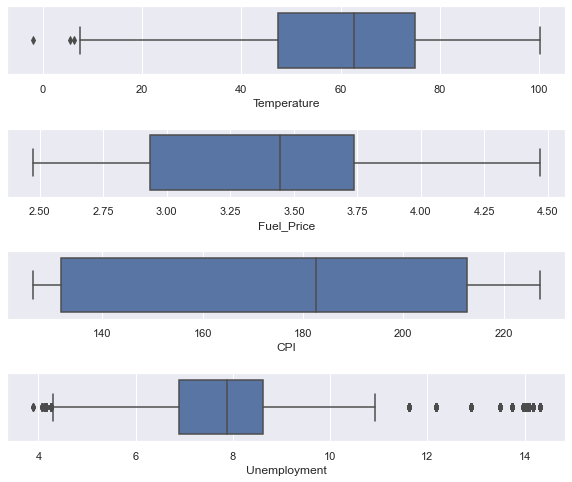

In [4]:
# fig, axs = plt.subplots(4)
# sns.boxplot(wall_data.Temperature, ax=axs[0])
# sns.boxplot(wall_data.Fuel_Price,ax=axs[1])
# sns.boxplot(wall_data.CPI,ax=axs[2])
# sns.boxplot(wall_data.Unemployment,ax=axs[3])

# fig, axs = plt.subplots(4,figsize=(10,8),constrained_layout = True)
X = wall_data[['Temperature','Fuel_Price','CPI','Unemployment']]
# X = wall_data.loc[:,['Temperature','Fuel_Price','CPI','Unemployment']]

fig, axs = plt.subplots(4,figsize=(10,8))
for i,j in enumerate(X):
    sns.boxplot(wall_data[j], ax=axs[i])
    fig.subplots_adjust(hspace=0.8)

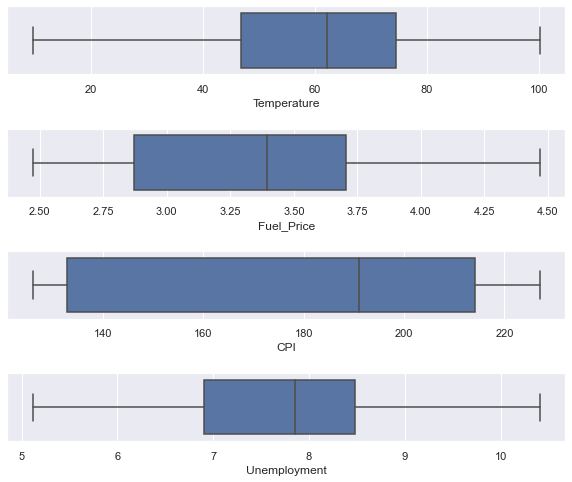

In [5]:
wall_data_2 = wall_data[(wall_data['Temperature']>8)&(wall_data['Unemployment']>=5)&(wall_data['Unemployment']<=10.5)]
X = wall_data_2[['Temperature','Fuel_Price','CPI','Unemployment']]
fig, axs = plt.subplots(4,figsize=(10,8))
for i,j in enumerate(X):
    sns.boxplot(wall_data_2[j], ax=axs[i])
    fig.subplots_adjust(hspace=0.8)

#### Importar librarias de regresión líneal, metricas y randomforest

In [6]:
# ------------------------------------------------ TODO ------------------------------------------------------ #
from sklearn.model_selection import train_test_split 
# Para series de tiempo no es bueno usar train_test_split. Ya que el trian y el test tienen datos
# de manera aleatoria. La segmentación se debe hacer por medio de peridodos de tiempo,
# es decir el train:antiguos,test:recientes
# Sólo se toma en cuenta Para los modelos regresion líneal, random forest y arbol de decisiones
# ------------------------------------------------ TODO ------------------------------------------------------ #
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#### Performance

In [7]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);
    
def cross_validation(model,a,b):
    cv = cross_val_score(model,a,b,cv=10,scoring='r2')
    print(f'Cross validation: {cv.mean()*100}%')

#### ADF

In [8]:
def adf(series,column_name):
    print(f'Resultados ADF: ,{column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)
    if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
        print('Los datos son estacionarios')
    else:
        print('Los datos no son estacionarios')

In [9]:
# Con base al número de tienda, el precio de la gasolina, el indice
# de precios al consumidor y la tasa de desempleo
X = wall_data.loc[:,['Store','Fuel_Price','CPI','Unemployment','year','month','day']] 

# Predecir las ventas por semana 
y = wall_data['Weekly_Sales']   

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) # corregir y segmentar

# Estandarización de los datos para eliminar outliers
sc = StandardScaler() #  (observacion - media) / sd
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [10]:
print(wall_data.shape[0],wall_data_2.shape[0],X_train.shape[0],X_test.shape[0], y_train.shape[0],y_test.shape[0])

# Variables independientes - Objetivo
# X_train # 80%
# X_test # 20%

# Variables que queremos predecir. Ventas semanales
# y_train
# y_test

6435 5733 5148 1287 5148 1287


## Linear regression

Accuracy train:  14.57961096091439
Accuracy test:  14.52934011830277
Mean Absolute Error:  423425.9079047064
Mean Square Error:  272533372724.41547
Root Mean Square Error:  522047.28973955556
Mean Absolute Percentage Error:  0.634164963303241
Cross validation: 14.179561928241272%


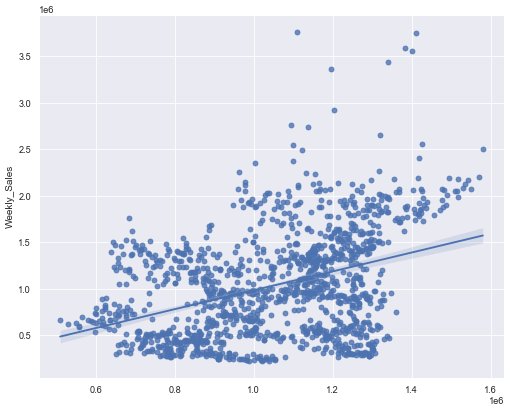

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)

# Medir la exactitud del modelo
print('Accuracy train: ', lin_reg.score(X_train,y_train)*100)
print('Accuracy test: ', metrics.r2_score(y_test,y_pred)*100)
performance(y_test,y_pred)
cross_validation(lin_reg,X_train,y_train)

## Random Forest

Accuracy train:  99.44646047272063
Accuracy test:  91.69561384025782
Mean Absolute Error:  83926.16967969298
Mean Square Error:  26479523752.982536
Root Mean Square Error:  162725.30151449263
Mean Absolute Percentage Error:  0.11735854859328788
Cross validation: 96.18281574960521%


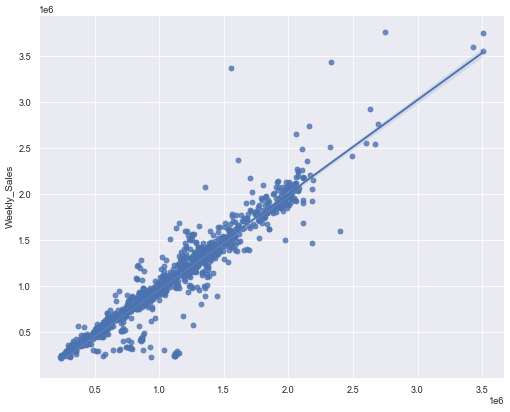

In [12]:
rdf = RandomForestRegressor(n_estimators=400,max_depth=15,n_jobs=5)
rdf.fit(X_train,y_train)
y_pred = rdf.predict(X_test)    

# Medir la exactitud del modelo
print('Accuracy train: ', rdf.score(X_train,y_train)*100)
print('Accuracy test: ', metrics.r2_score(y_test,y_pred)*100)
performance(y_test,y_pred)
cross_validation(rdf,X_train,y_train)

## Decision Tree Regressor

Accuracy train:  99.81571402941388
Accuracy test:  86.41002392498179
Mean Absolute Error:  96891.35534438075
Mean Square Error:  43333256348.96553
Root Mean Square Error:  208166.41503606082
Mean Absolute Percentage Error:  0.13380849548896356
Cross validation: 94.5077692109795%


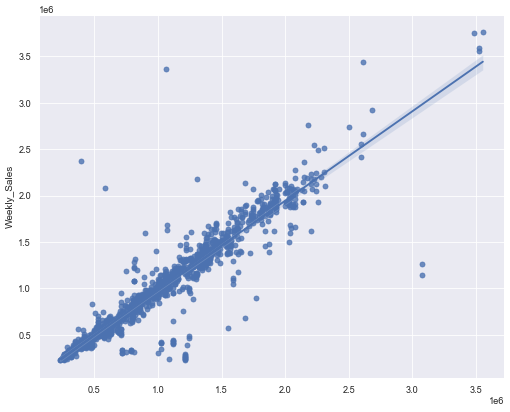

In [13]:
dtr = DecisionTreeRegressor(max_depth=15)
dtr.fit(X_train,y_train)
y_pred = dtr.predict(X_test)    

# Medir la exactitud del modelo
print('Accuracy train: ', dtr.score(X_train,y_train)*100)
print('Accuracy test: ', metrics.r2_score(y_test,y_pred)*100)
performance(y_test,y_pred)
cross_validation(dtr,X_train,y_train)

## Series de Tiempo

## Semanal

#### Tienda 20

<AxesSubplot:>

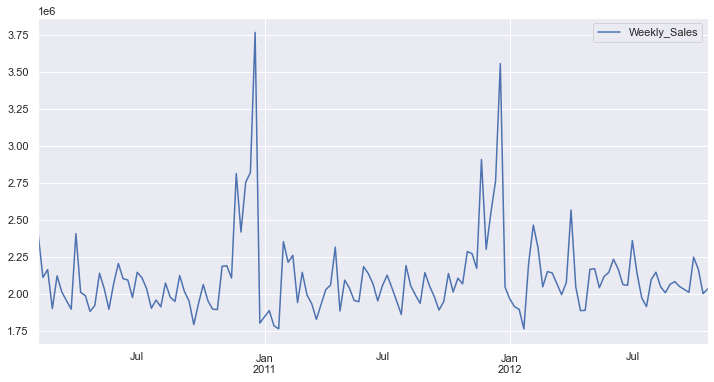

In [50]:
wall_data_store_20 = wall_data[wall_data['Store']==20].iloc[:,[1,2]]
wall_data_store_20.set_index('Date',inplace=True)
wall_data_store_20 = wall_data_store_20.rename_axis(index=None,columns=None)
# wall_data_store_20
# wall_data_store_20.Weekly_Sales

# De un dataframe. Hacer una serie de tiempo
# df.Meses = pd.to_datetime(df.Meses)
# Organiza en meses los indices de la serie de tiempo
# df = d.set_index('Meses')
# df.head()

plt.rcParams["figure.figsize"] = (12,6)
wall_data_store_20.plot()

In [51]:
adf(wall_data_store_20.Weekly_Sales,'Weekly_Sales')

Resultados ADF: ,Weekly_Sales
Test Statistic           -5.39
p-value                   0.00
No Lags Used              4.00
Observation number      138.00
Critical Values (1%)     -3.48
Critical Values (5%)     -2.88
Critical Values (10%)    -2.58
dtype: float64
Los datos son estacionarios


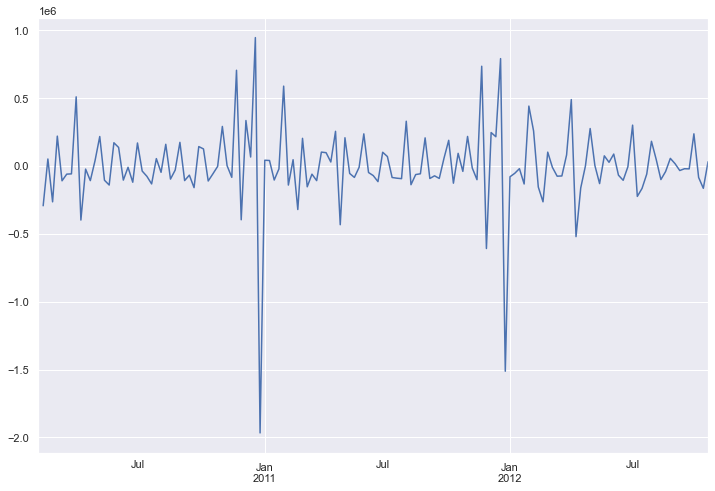

In [52]:
prev_store_20_value = wall_data_store_20.Weekly_Sales.shift()
differenced_store_20 = wall_data_store_20.Weekly_Sales - prev_store_20_value
plt.rcParams["figure.figsize"] = (12,8)
differenced_store_20.plot();

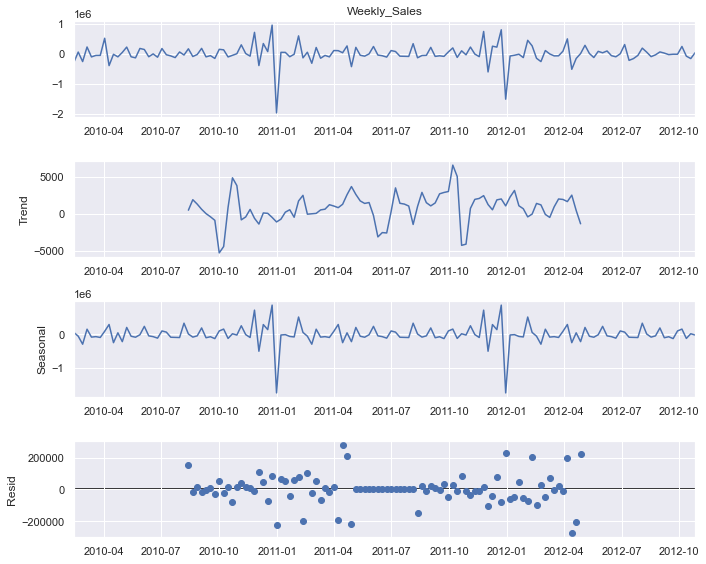

In [53]:
differenced_store_20_dif = seasonal_decompose(differenced_store_20.iloc[1:],model='additive',period = 52)
# differenced_store_20_dif = seasonal_decompose(differenced_store_20.iloc[1:],model='additive')
plt.rcParams["figure.figsize"] = (10,8)
differenced_store_20_dif.plot();

### ARIMA

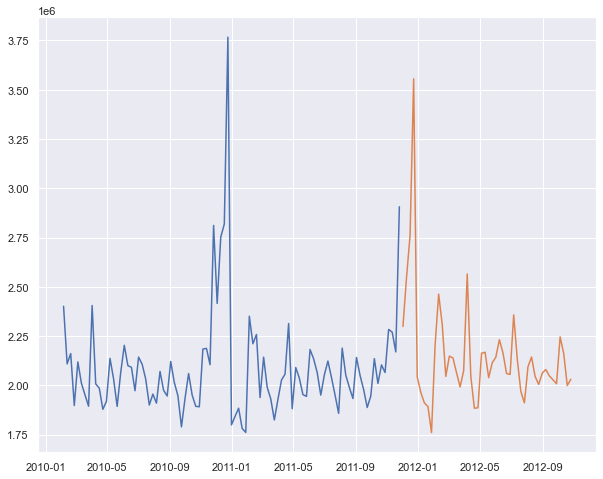

In [62]:
train = wall_data_store_20.Weekly_Sales[:len(wall_data_store_20.Weekly_Sales)-48]  # primero datos
test = wall_data_store_20.Weekly_Sales[len(wall_data_store_20.Weekly_Sales)-48:]   # últimos datos 
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(train)
plt.plot(test)

# Para determinar el train yel test, se sugiere que lso datos asignados sean del 80% y 20% sucesivamente
# pero a mayor número de datos de entrenamiento, el AIC disminuye y el R2 aumenta
# caso contrario, el AIC aumenta y el R2 se hace negativo
# ¿De qupe depende el periodo que se quiere calcular?. Por ejemplo, yo determine 48 semanas que se quieren predecir

In [70]:
print(len(train),len(test))

95 48


In [64]:
# Nunca se debe utilizar toda la información de un dataset, debe ser el dataset de train 
# para el entrenamiento de los modelo.
# El test nunca filtra inforamción al train.
arima_model = pm.auto_arima(train, start_p=0,d=0,start_q=0,max_p=5,max_d=5,max_q=5,
                            start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=52,
                            seasonal=True,error_Action='warn',trace=True,test='adf',
                            supress_warnings = True, stepwise=True, random_state=20,
                            n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1135.241, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1139.189, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1139.307, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1153.186, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1137.210, Time=0.88 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1137.210, Time=0.36 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=3.67 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1137.192, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1137.314, Time=0.17 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1139.263, Time=0.32 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 7.302 seconds


#### SARIMAX

In [65]:
# D:parametro parte estacional, d:parametro parte no estacional
# from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(train,order=(0,0,0),seasonal_order = (0,1,0,52))     #AIC 1,858.557; D=1;d=0  /// predecir 48 seamanas o 32 semanas AIC 1,575.718; D=1;d=0
# arima_model = SARIMAX(train,order=(1,0,1),seasonal_order = (0,1,2,52))     #AIC 2,184.648; D=1;d=0 /// predecir 6 seamanas

arima_result = arima_model.fit() 
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:             Weekly_Sales   No. Observations:                   95
Model:             SARIMAX(0, 1, 0, 52)   Log Likelihood                -575.593
Date:                  Sat, 03 Dec 2022   AIC                           1153.186
Time:                          00:45:54   BIC                           1154.947
Sample:                      02-05-2010   HQIC                          1153.836
                           - 11-25-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.399e+09   3.66e+08     20.238      0.000    6.68e+09    8.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                77.88
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.52
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
arima_result.model_orders
# r2. si no hay una cte (ar,phi_0) en el modelo. este es negativo.

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 0,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 0,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [67]:
arima_pred = arima_result.predict(start= len(train),end=len(wall_data_store_20)-1,type='levels').rename('ARIMA Predictions')
arima_pred
# el autoarima no tiene una cte 

2011-12-02   2,416,051.17
2011-12-09   2,752,122.08
2011-12-16   2,819,193.17
2011-12-23   3,766,687.43
2011-12-30   1,799,737.79
2012-01-06   1,843,030.95
2012-01-13   1,884,345.01
2012-01-20   1,781,805.66
2012-01-27   1,761,506.68
2012-02-03   2,351,143.07
2012-02-10   2,211,388.14
2012-02-17   2,258,616.24
2012-02-24   1,938,608.52
2012-03-02   2,143,424.61
2012-03-09   1,990,932.77
2012-03-16   1,931,668.64
2012-03-23   1,824,711.21
2012-03-30   1,927,993.09
2012-04-06   2,027,056.39
2012-04-13   2,057,406.33
2012-04-20   2,313,861.81
2012-04-27   1,881,788.19
2012-05-04   2,090,838.44
2012-05-11   2,036,748.53
2012-05-18   1,953,416.06
2012-05-25   1,944,433.17
2012-06-01   2,182,246.69
2012-06-08   2,135,062.04
2012-06-15   2,065,191.27
2012-06-22   1,950,826.32
2012-06-29   2,053,165.41
2012-07-06   2,123,787.79
2012-07-13   2,039,875.75
2012-07-20   1,950,904.84
2012-07-27   1,858,440.92
2012-08-03   2,189,353.63
2012-08-10   2,052,246.40
2012-08-17   1,990,017.93
2012-08-24  

<AxesSubplot:>

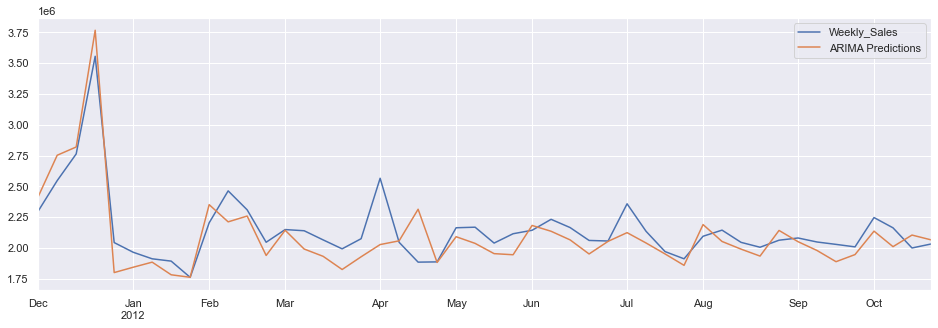

In [68]:
# plt.plot(train)
# plt.plot(test)
# plt.plot(arima_pred)
# wall_data_store_20.Weekly_Sales.plot(figsize=(16,5),legend=True)
test.plot(figsize=(16,5),legend=True)
arima_pred.plot(legend=True)

Accuracy test(R2):  69.31876750911997
Mean Absolute Error:  115513.64166666666
Mean Square Error:  23373840437.357723
Root Mean Square Error:  152885.05629183556
Mean Absolute Percentage Error:  0.05279421488588142


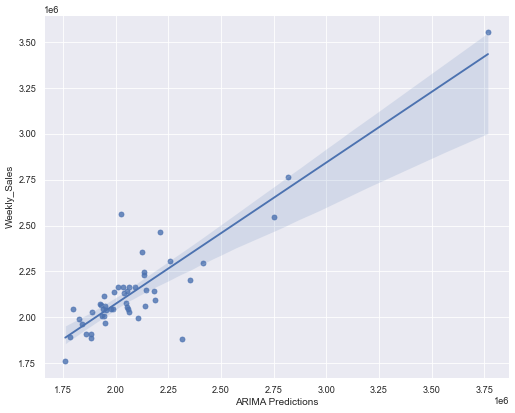

In [69]:
print('Accuracy test(R2): ', metrics.r2_score(test,arima_pred)*100)
performance(test,arima_pred)

## Mensual

#### Tienda 20

In [27]:
wall_data_store_20 = wall_data[wall_data['Store']==20].iloc[:,[1,2,8,9,10]]
# wall_data_store_20 
wall_data_store_20_promedio_mensual= wall_data_store_20.groupby(['year','month'])[['Weekly_Sales']].mean().reset_index()
wall_data_store_20_promedio_mensual['year_str']=wall_data_store_20_promedio_mensual.year.apply(str)
wall_data_store_20_promedio_mensual['month_str']=wall_data_store_20_promedio_mensual.month.apply(str)
# wall_data_store_20_promedio_mensual.info()
wall_data_store_20_promedio_mensual['year_month'] = wall_data_store_20_promedio_mensual[['year_str','month_str']].apply('-'.join,axis=1)
# wall_data_store_20_promedio_mensual.head()
wall_data_store_20_promedio_mensual['Date']=pd.to_datetime(wall_data_store_20_promedio_mensual['year_month'],format="%Y-%m",yearfirst=True)
wall_data_store_20_promedio_mensual = wall_data_store_20_promedio_mensual.iloc[:,[6,2]]
wall_data_store_20_promedio_mensual.head()

,Date,Weekly_Sales
0,2010-02-01,"2,142,561.77"
1,2010-03-01,"1,994,194.99"
2,2010-04-01,"2,039,378.34"
3,2010-05-01,"2,032,533.96"
4,2010-06-01,"2,092,287.16"


<AxesSubplot:>

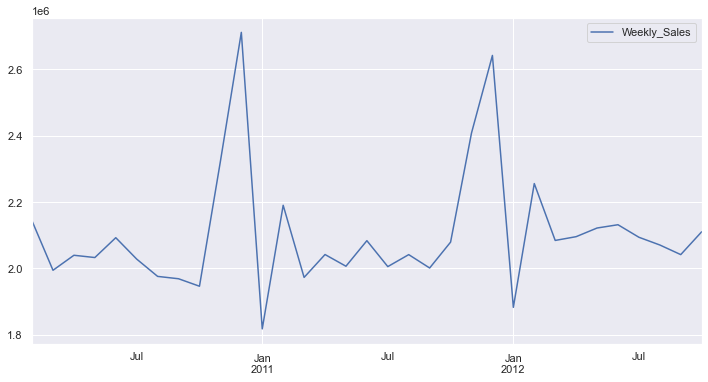

In [28]:
wall_data_store_20_promedio_mensual.set_index('Date',inplace=True)
wall_data_store_20_promedio_mensual = wall_data_store_20_promedio_mensual.rename_axis(index=None, columns = None)
plt.rcParams["figure.figsize"] = (12,6)
wall_data_store_20_promedio_mensual.plot()

In [29]:
adf(wall_data_store_20_promedio_mensual.Weekly_Sales,'Weekly_Sales')

Resultados ADF: ,Weekly_Sales
Test Statistic          -5.57
p-value                  0.00
No Lags Used             0.00
Observation number      32.00
Critical Values (1%)    -3.65
Critical Values (5%)    -2.96
Critical Values (10%)   -2.62
dtype: float64
Los datos son estacionarios


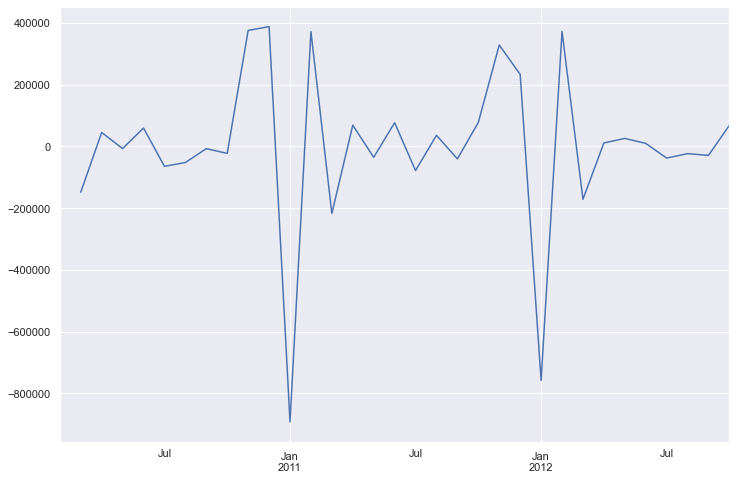

In [30]:
prev_store_20_value = wall_data_store_20_promedio_mensual.Weekly_Sales.shift()
differenced_store_20 = wall_data_store_20_promedio_mensual.Weekly_Sales - prev_store_20_value
plt.rcParams["figure.figsize"] = (12,8)
differenced_store_20.plot();

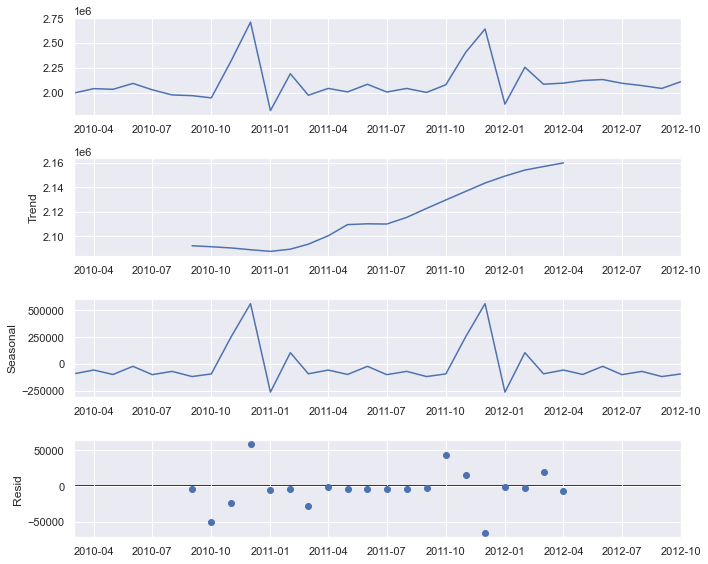

In [31]:
differenced_store_20_dif = seasonal_decompose(wall_data_store_20_promedio_mensual.iloc[1:],model='additive',period = 12)
plt.rcParams["figure.figsize"] = (10,8)
differenced_store_20_dif.plot();

### ARIMA

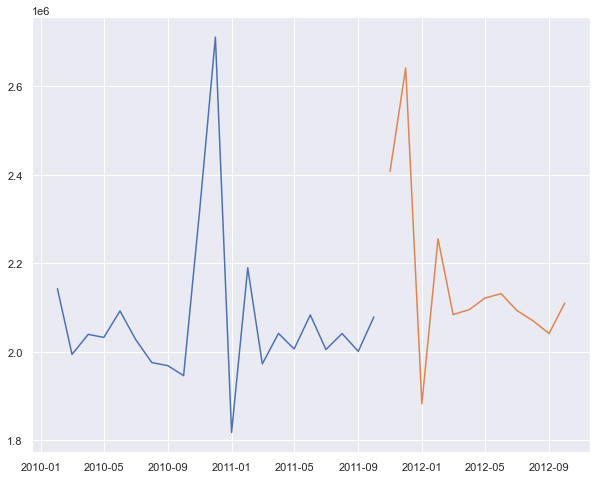

In [45]:
train = wall_data_store_20_promedio_mensual.Weekly_Sales[:len(wall_data_store_20_promedio_mensual.Weekly_Sales)-12]  # primero datos
test = wall_data_store_20_promedio_mensual.Weekly_Sales[len(wall_data_store_20_promedio_mensual.Weekly_Sales)-12:]   # últimos datos
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(train)
plt.plot(test)

In [46]:
# Nunca se debe utilizar toda la información de un dataset, debe ser el dataset de train 
# para el entrenamiento de los modelo.
# El test nunca filtra inforamción al train.
arima_model = pm.auto_arima(train, start_p=0,d=0,start_q=0,max_p=5,max_d=5,max_q=5,
                            start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=12,
                            seasonal=True,error_Action='warn',trace=True,test='adf',
                            supress_warnings = True, stepwise=True, random_state=20,
                            n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=224.291, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=228.002, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=228.362, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=224.829, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=226.290, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=226.290, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=226.011, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=226.444, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=225.971, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.806 seconds


#### SARIMAX

In [47]:
# D:parametro parte estacional, d:parametro parte no estacional
# from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(train,order=(0,0,0),seasonal_order = (0,1,0,12))     #AIC 380.096; D=1;d=0
arima_result = arima_model.fit() 
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:             Weekly_Sales   No. Observations:                   21
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -111.415
Date:                  Sat, 03 Dec 2022   AIC                            224.829
Time:                          00:18:29   BIC                            225.026
Sample:                      02-01-2010   HQIC                           224.403
                           - 10-01-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.978e+09   4.81e+08      4.117      0.000    1.04e+09    2.92e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.61   Prob(JB):                         0.48
Heteroskedasticity (H):               8.48   Skew:                             0.99
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
arima_result.model_orders
# r2. si no hay una cte (ar,phi_0) en el modelo. este es negativo.

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 0,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 0,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [49]:
arima_pred = arima_result.predict(start=len(train),end=len(wall_data_store_20_promedio_mensual)-1,type='levels').rename('ARIMA Predictions')
arima_pred
# el autoarima no tiene una cte 

2011-11-01   2,322,193.72
2011-12-01   2,710,758.33
2012-01-01   1,817,672.07
2012-02-01   2,189,938.99
2012-03-01   1,972,684.31
2012-04-01   2,041,621.16
2012-05-01   2,006,359.05
2012-06-01   2,083,331.58
2012-07-01   2,005,234.94
2012-08-01   2,041,298.79
2012-09-01   2,001,049.19
2012-10-01   2,078,938.47
Freq: MS, Name: ARIMA Predictions, dtype: float64

<AxesSubplot:>

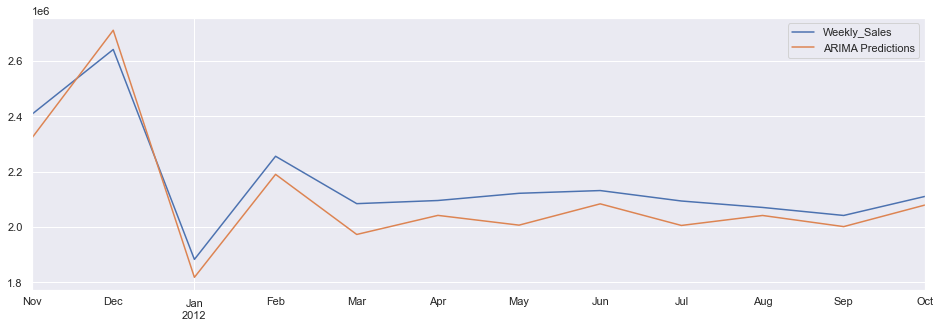

In [50]:
test.plot(figsize=(16,5),legend=True)
arima_pred.plot(legend=True)

Accuracy test(R2):  85.08172077109136
Mean Absolute Error:  66852.11704166663
Mean Square Error:  5224463219.885597
Root Mean Square Error:  72280.44839294784
Mean Absolute Percentage Error:  0.030986461666270827


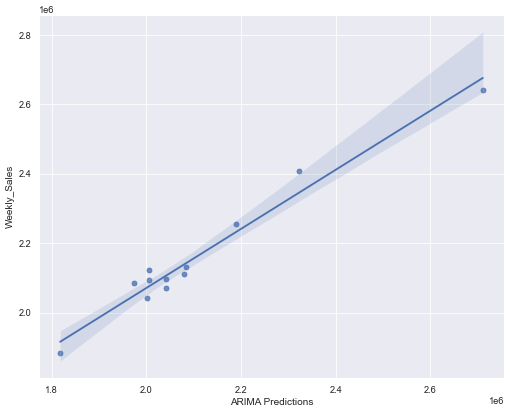

In [51]:
print('Accuracy test(R2): ', metrics.r2_score(test,arima_pred)*100)
performance(test,arima_pred)
